In [1]:
import numpy as np
import pandas as pd
from plotnine import *
from scipy.stats import binom, uniform

$\DeclareMathOperator*{\MEAN}{\mathbf{E}}$
$\DeclareMathOperator*{\VARIANCE}{\mathbf{D}}$
$\newcommand{\mean}[1]{\MEAN\left[#1\right]}$
$\newcommand{\variance}[1]{\VARIANCE\left[#1\right]}$
$\newcommand{\prob}[1]{\Pr\left[#1\right]}$
$\newcommand{\accuracy}{Acc}$
$\newcommand{\precision}{Prec}$
$\newcommand{\recall}{Rec}$

## Õigsuse lähendi absoluutne viga

Valimi põhjal leitud lähendid kvaliteedimõõtudele sisaldavad viga.
Veendumaks lähendi vastavuses selle täpsele väärtusele tekib küsimus vea suuruse kohta.
Vea arvutamiseks peab teadma täpset väärtust, mis ei pruugi olla võimalik.
Täpset väärtust teadmata saab viga hinnata tõenäosuslikult.
Sageli seatakse eesmärgiks hinnata kui suur on viga $95\%$ juhtudest.

Üks viis vea tõenäosuslikuks hindamiseks on kasutada konsentratsioonivõrratusi, näitkes Höffdingi võrratust.
Höffdingi võrratus on suurte arvude seaduse konkreetne erijuht, mis annab üldistest hinnangutest täpsemaid tõkkeid tõenäosustele.
Höffdingi võrratus sätib ülemise tõkke tõenäosusele, et tõkestatud paarikaupa sõltumatute juhuslike suuruste summa erineb selle summa keskväärtusest (oodatud väärtusest) vähemalt mingi konstandi võrra \cite{hoeffding,tnt2}.
Täpsemalt, kui juhuslikud suurused $Z_1,Z_2,\dots,Z_N$ on sõltumatud ning leiduvad tõkked
\begin{equation*}
    a_i\leq Z_i\leq b_i \enspace, 
\end{equation*}
siis summa $S_N=Z_1+\cdots+Z_N$ ning iga positiivse $c$ korral
\begin{equation*}
    \prob{|S_N-\mean{S_N}|\geq c}\leq2\exp{\left(-\frac{2c^2}{\sum_{i=1}^{N}(b_i-a_i)^2}\right)} \enspace.
\end{equation*}

Kuna Bernoulli jaotusega juhuslike suuruste jaoks leiduvad tõkked $0\leq Z_i\leq1$ järeldub Höffdingi võrratusest seos
\begin{equation}
    \label{eq:höffding absoluutne viga}
    \prob{\mid\widehat{\accuracy}-\accuracy\mid\geq\frac{c}{N}}\leq2\exp{\left(-\frac{2c^2}{N}\right)} \enspace,
\end{equation}
mille põhjal saab hinnata lähendi $\widehat{\accuracy}$ absoluutse vea alumise tõkke tõenäosust.
Sättides võrratuse parema poole võrdseks olulisusega $\alpha$ avaldub veahinnangu alumine tõke kujul
\begin{equation*}
     \varepsilon:=\frac{c}{N}=\sqrt{-\frac{1}{2N}\cdot\ln{\left(\frac{\alpha}{2}\right)}} \enspace.
\end{equation*}
Tulemust kasutades on võimalik leida valimi vajalik suurus
\begin{equation*}
    N \geq -\frac{1}{2\varepsilon^2}\cdot\ln{\left(\frac{\alpha}{2}\right)} \enspace,
\end{equation*}
et fikseeritud olulisuse korral saavutada soovitud suurusega veahinnang.

| $1 − \alpha$ | $\varepsilon = 10\%$ | $\varepsilon = 1\%$ | $\varepsilon = 0.1\%$ |
|--------------|----------------------|---------------------|-----------------------|
| $99\% (3σ)$   | $265$                | $26492$             | $2649159$             |
| $95\% (2σ)$   | $185$                | $18445$             | $1844440$             |
| $68\% (1σ)$   | $92$                 | $9163$              | $916291$              |

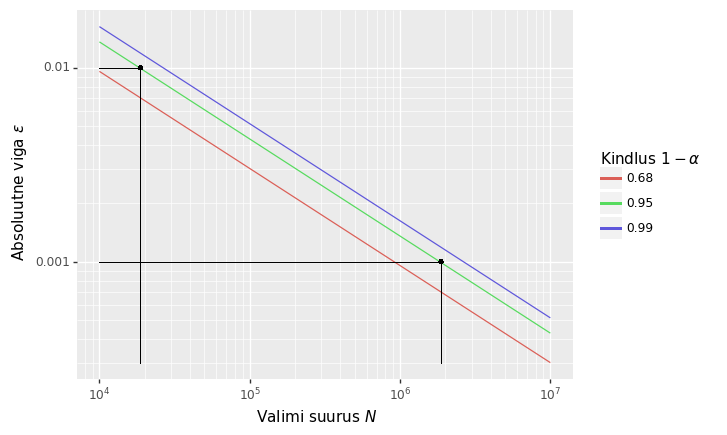

<ggplot: (143701916429)>

In [2]:
N = np.logspace(4, 7, 100)
olulisused = .01, .05, .32

read = np.array([
    (round(1 - a, 2), n, np.sqrt(-np.log(a / 2) / (2 * n)))
    for a in olulisused
    for n in N
])

df = pd.DataFrame(read, columns=['kindlus', 'n', 'epsilon'])

k95 = df.query('kindlus == .95')
n_k95_e01 = k95.iloc[np.abs(k95['epsilon'] - .01).argmin()]['n']
n_k95_e001 = k95.iloc[np.abs(k95['epsilon'] - .001).argmin()]['n']
eps_min = df['epsilon'].min()

g = (
    ggplot(df) +
    scale_x_log10(breaks=np.logspace(4, 7, 4), labels=['$10^4$', '$10^5$', '$10^6$', '$10^7$']) +
    scale_y_log10(breaks=np.logspace(-3, -1, 3)) +
    aes('n', 'epsilon', group='kindlus', color='pd.Categorical(kindlus)') +
    labs(x='Valimi suurus $N$', y='Absoluutne viga $\\varepsilon$') +
    guides(color=guide_legend(title='Kindlus $1-\\alpha$')) +
    
    geom_line() +
    
    geom_segment(aes(x=n_k95_e01, y=eps_min, xend=n_k95_e01, yend=.01), size=.25, color="black", show_legend=False) +
    geom_segment(aes(x=n_k95_e001, y=eps_min, xend=n_k95_e001, yend=.001), size=.25, color="black", show_legend=False) +
    geom_segment(aes(x=1e4, y=.01, xend=n_k95_e01, yend=.01), size=.25, color="black", show_legend=False) +
    geom_segment(aes(x=1e4, y=.001, xend=n_k95_e001, yend=.001), size=.25, color="black", show_legend=False) +
    
    geom_point(aes(x='n_k95_e01', y='.01'), size=0.75, color="black", show_legend=False) +
    geom_point(aes(x='n_k95_e001', y='.001'), size=0.75, color="black", show_legend=False)
)

# g.save('./joonised/hoeffding_absoluutne_viga.png', dpi=100)
g

Tabelis on välja toodud vajalik valimi suurus soovitud kindluse ja lähendi absoluutse vea suhtes Höffdingi võrratuse põhjal, kindluse puhul on sulgudes tähistatud, kui mitu normaaljaotuse standardhälvet $\sigma$ keskväärtuse ümbruses see katab.
Näiteks kui on soov olla $95\%$ kindel, et valimi põhjal arvutatud õigsus $\widehat{\accuracy}$ erineb algoritmi tegelikust õigsusest kuni ühe protsendi võrra, peab õigsust hindama valimil suurusega vähemalt $18504$.
Joonisel on sama mõttekäik esitatud graafiliselt.

Õigsuse lähendi absoluutse vea hindamiseks saab ka kasutada asjaolu, et suurused $Z_i$ on Bernoulli jaotusega.
See tähendab, et summa
\begin{equation*}
    S_N=\sum^{N}_{i = 1}Z_i \enspace,
\end{equation*}
on binoomjaotusega.
Mingi binoomjaotusega juhusliku suuruse $X$ puhul tähistatakse seda $X\sim\mathcal{B}(n, p)$, kus parameeter $n$ on Bernoulli katsete arv ja $p$ katse õnnestumise tõenäosus.
Sellest lähtudes saab õelda
\begin{equation*}
    S_N\sim\mathcal{B}(N, \accuracy) \enspace.
\end{equation*}
Seega on õigsuse lähend $\widehat{\accuracy}$ binoomjaotusega juhsuliku suuruse skaleering. 
Eespool uuritud Höffdingi võrratusel põhinevad tõkked selle omadusega ei arvestanud ning olid binoomjaotuse parameetrist $p$ sõltumatud, tegu oli konservatiivse hinnanguga.
Höffidngi võrratus on univarsaalne üle kõikide binoomjaotuse parameetrite $p$, millest halvim variant realiseerub juhul $p=0{,}5$.
Binoomjaotusel põhinevad tõkked on täpsed ning annavad aimu Höffidngi võrratuse tulemuste ebatäpsustest.
Lisaks näitavad binoomjaotusel põhinevad arvutused kuidas meetodi tegelik õigsus $\accuracy$ mõjutab tulemusi.

Kasutades teadmist, et uuritav summa on binoomjaotusega saab leida jaotuse parameetritest sõltuva hinnangu.
Olulisuse $\alpha$ korral saab absoluutse veahinnangu tõkke $\varepsilon$ arvutada lähtudes võrrandist
\begin{equation}
    \label{eq:binoomjaotus absoluutne viga}
    \prob{\mid\widehat{\accuracy}-\accuracy\mid\geq\varepsilon}=\alpha \enspace,
\end{equation}
ning valides protsendipunktid sümmetriliselt
\begin{align*}
    \prob{\widehat{\accuracy} \leq \accuracy-\varepsilon} &= \frac{\alpha}{2} \enspace,\\
    \prob{\widehat{\accuracy} <    \accuracy+\varepsilon} &= 1 - \frac{\alpha}{2} \enspace,
\end{align*}
millest binoomjaotusega juhusliku suuruse $S_N$ eraldamisel ühele poole võrratuse märki saab
\begin{align*}
    \prob{S_N \leq N \cdot(\accuracy-\varepsilon)} &= \frac{\alpha}{2} \enspace,\\
    \prob{S_N < N \cdot(\accuracy+\varepsilon)} &= 1 - \frac{\alpha}{2} \enspace.
\end{align*}
Paremale poole võrratuse märki tekkinud avaldised on $S_N$ jaotuse vastavalt $\frac{\alpha}{2}$ ja $1-\frac{\alpha}{2}$ protsendipunktid, ehk väärtused, millest $S_N$ võtab väiksemaid väärtusi protsenidpunktile vastava tõenäosusega
\begin{align*}
    q_1 &= N \cdot(\accuracy-\varepsilon) \enspace, \\
    q_2 &= N \cdot(\accuracy+\varepsilon) \enspace. \\
\end{align*}
Fikseeritud olulisuse ja binoomjaotuse parameetrite korral on protsendipunkt arvutatav kasutades $S_N$ jaotuse omadusi. 

Absoluutse vea tõkkeks $\varepsilon$ on valitud suurem protsentipunktide põhjal arvutatud veahinnang
\begin{equation}
    \label{eq:binoomjaotus absoluutne viga tõke}
    \varepsilon = \max \left( \accuracy - \frac{q_1}{N} , \frac{q_2}{N} - \accuracy \right) \enspace.
\end{equation}
Parameetri $N$ kasvades koondub binoomjaotus noramaaljaotuseks \cite{tnt}.
Seega suuremate $N$ väärtuste puhul muutub binoomjaotus sümmetriliseks, järelikult erinevad $q_1$ ja $q_2$ põhjal arvutatud veahinnangute väärtused tegelikkuses vähe.
Tulemust kasutades saab arvutada vajaliku valim suuruse soovitud olulisuse suhtes, kuid selle jaoks peab tegema mudeli tegeliku õigsuse $p$ kohta oletusi.

| $\accuracy$ | $\varepsilon = 10\%$ | $\varepsilon = 1\%$     | $\varepsilon = 0.1\%$     |
|-------------|----------------------|-------------------------|---------------------------|
| $70\%$      | $75\enspace(2{,}47)$ | $8100\enspace(2{,}28)$  | $806289\enspace(2{,}29)$  |
| $90\%$      | $35\enspace(5{,}29)$ | $3600\enspace(5{,}12)$  | $347020\enspace(5{,}32)$  |
| $95\%$      | $20\enspace(9)$      | $1850\enspace(9{,}97)$  | $183285\enspace(10{,}06)$ |

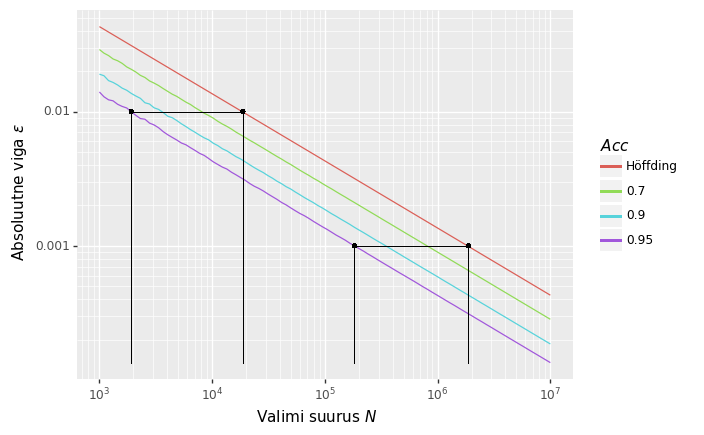

<ggplot: (143702874149)>

In [3]:
N = np.round(np.logspace(3, 7, 100), 0)  # binom.ppf() ei salli komakohti ???
tõenäosused = .7, .9, .95

read = [
    (p, n, max(p - binom.ppf(q=0.025, p=p, n=n) / n, binom.ppf(q=1 - 0.025, p=p, n=n) / n - p)) for p in tõenäosused for n in N
]  # binoom
read += [(-1, n, np.sqrt(-np.log(.025) / (2 * n))) for n in N]  # höffding
df = pd.DataFrame(read, columns=['tõenäosus', 'n', 'epsilon'])

p95 = df.query('tõenäosus == .95')
n_p95_e01 = p95.iloc[np.abs(p95['epsilon'] - .01).argmin()]['n']
n_p95_e001 = p95.iloc[np.abs(p95['epsilon'] - .001).argmin()]['n']
eps_min = df['epsilon'].min()

g = (
    ggplot(df) +
    scale_x_log10(breaks=np.logspace(3, 7, 5), labels=['$10^3$','$10^4$', '$10^5$', '$10^6$', '$10^7$']) +
    scale_y_log10(breaks=np.logspace(-3, -1, 3)) +
    labs(x='Valimi suurus $N$', y='Absoluutne viga $\\varepsilon$') +
    guides(color=guide_legend(title='$Acc$')) +
    scale_color_discrete(labels=['Höffding', .7, .9, .95]) +

    geom_line(aes('n', 'epsilon', group='tõenäosus', color='pd.Categorical(tõenäosus)')) +
    
    geom_segment(aes(x=n_k95_e01, y=eps_min, xend=n_k95_e01, yend=.01), size=.25, color="black", show_legend=False) +
    geom_segment(aes(x=n_k95_e001, y=eps_min, xend=n_k95_e001, yend=.001), size=.25, color="black", show_legend=False) +
    geom_segment(aes(x=n_p95_e01, y=eps_min, xend=n_p95_e01, yend=.01), size=.25, color="black", show_legend=False) +
    geom_segment(aes(x=n_p95_e001, y=eps_min, xend=n_p95_e001, yend=.001), size=.25, color="black", show_legend=False) +
    geom_segment(aes(x=n_p95_e01, y=.01, xend=n_k95_e01, yend=.01), size=.25, color="black", show_legend=False) +
    geom_segment(aes(x=n_p95_e001, y=.001, xend=n_k95_e001, yend=.001), size=.25, color="black", show_legend=False) +
    
    geom_point(aes(x='n_p95_e01', y='.01'), size=0.75, color="black", show_legend=False) +
    geom_point(aes(x='n_p95_e001', y='.001'), size=0.75, color="black", show_legend=False) +
    geom_point(aes(x='n_k95_e01', y='.01'), size=0.75, color="black", show_legend=False) +
    geom_point(aes(x='n_k95_e001', y='.001'), size=0.75, color="black", show_legend=False)
)

# g.save('./joonised/binoomjaotus_absoluutne_viga.png', dpi=100)
g

Tabelis ja joonisel on esitatud valimi vajalikud suurused meetodi oletatud õigsuse ja absoluutse veahinnangu soovitud suuruse suhtes binoomjaotuse omaduste põhjal kindlusega $95\%$.
Võrdluseks on välja toodud ka Höffdingi võrratusel põhinevad tulemused sama kindlusega, joonisel on see esitatud eraldi joonega, tabelis on sulgudes kirjas kui mitu korda on Höffdingi võrratuse põhine valim suurem.
Eeldusel, et algoritmi tegelik õigsus on $90\%$, on absoluutne viga kuni üks protsent läheb vaja valimit suurusega $3520$, mis on umbes viis korda väiksem kui valimi mida on vaja Höffdingi võrratuse põhjal.